In [238]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [425]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

from sklearn.ensemble import VotingRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import SCORERS
from sklearn.metrics import r2_score

from fitter import Fitter, get_common_distributions, get_distributions

In [305]:
df = pd.read_csv("abalone.csv")

In [306]:
df.head(2)

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.15,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.07,7


In [307]:
df.Rings.unique()

array([15,  7,  9, 10,  8, 20, 16, 19, 14, 11, 12, 18, 13,  5,  4,  6, 21,
       17, 22,  1,  3, 26, 23, 29,  2, 27, 25, 24])

In [308]:
X = df.drop(columns = 'Rings')

In [309]:
df['age'] = df['Rings']+1.5
y = df['age']

In [310]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [370]:
X_train_alive = X_train[['Length','Diameter','Height']]
X_test_alive = X_test[['Length','Diameter','Height']]

In [371]:
X_train_alive.head(2)

,Length,Diameter,Height
1734,0.67,0.505,0.16
361,0.59,0.465,0.15


In [372]:
import math

class AreaTransformer(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        '''A=πab'''
        X_ = X.copy()
        X_["area"] = math.pi * X_['Length']/2 * X_['Diameter']/2
        return X_[["area"]]

In [380]:
trans = ColumnTransformer(
    [#('ohe', OneHotEncoder(drop = 'first'), ['Sex']),
    ('area', AreaTransformer(), ['Length', 'Diameter'])],
    remainder = 'passthrough')

In [381]:
preproc = Pipeline([
    ('encoder', trans),
    ('scaler', StandardScaler())
])

In [375]:
lin_reg = Pipeline([
    ('preproc', preproc),
    ('model', LinearRegression())
])

In [376]:
res = cross_validate(lin_reg, 
               X_train, 
               y_train, 
               cv = 5, 
               scoring = ['neg_mean_absolute_error','neg_mean_absolute_percentage_error', 'r2'])

print('abs error: ', res['test_neg_mean_absolute_error'].mean())
print('% error: ', res['test_neg_mean_absolute_percentage_error'].mean())
print('r2: ', res['test_r2'].mean())

abs error:  -1.5987192095804375
% error:  -0.13884715558894034
r2:  0.5109594159403119


In [377]:
gbr = Pipeline([
    ('preproc', preproc),
    ('gbr', GradientBoostingRegressor(n_estimators=500,
                               max_depth=3))
])

res = cross_validate(gbr, 
               X_train_alive, 
               y_train, 
               cv = 5, 
               scoring = ['neg_mean_absolute_error','neg_mean_absolute_percentage_error', 'r2'])

print('abs error: ', res['test_neg_mean_absolute_error'].mean())
print('% error: ', res['test_neg_mean_absolute_percentage_error'].mean())
print('r2: ', res['test_r2'].mean())

abs error:  nan
% error:  nan
r2:  nan


/Users/alecsharp/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/alecsharp/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/pandas/core/indexes/base.py", line 2895, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas/_libs/index.pyx", line 70, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 101, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 1675, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 1683, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'Sex'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "

In [334]:
svr = Pipeline([
    ('preproc', preproc),
    ('gbr', SVR(C=1.0, epsilon=0.2))
])

res = cross_validate(svr, 
               X_train_alive, 
               y_train, 
               cv = 5, 
               scoring = ['neg_mean_absolute_error','neg_mean_absolute_percentage_error', 'r2'])

print('abs error: ', res['test_neg_mean_absolute_error'].mean())
print('% error: ', res['test_neg_mean_absolute_percentage_error'].mean())
print('r2: ', res['test_r2'].mean())

abs error:  -1.677687693204519
% error:  -0.13410469309687983
r2:  0.3799202146732559


In [319]:
rf = Pipeline([
    ('preproc', preproc),
    ('rf', RandomForestRegressor(n_estimators = 400))  
])


In [281]:
res = cross_validate(rf, 
               X_train, 
               y_train, 
               cv = 5, 
               scoring = ['neg_mean_absolute_error','neg_mean_absolute_percentage_error', 'r2'])

print('abs error: ', res['test_neg_mean_absolute_error'].mean())
print('% error: ', res['test_neg_mean_absolute_percentage_error'].mean())
print('r2: ', res['test_r2'].mean())

abs error:  -1.5467659641728133
% error:  -0.13188797264792762
r2:  0.5292445893175196


In [282]:
knn = Pipeline([
    ('preproc', preproc),
    ('knn', KNeighborsRegressor(n_neighbors = 3))  
])


In [283]:
res = cross_validate(knn, 
               X_train_alive, 
               y_train, 
               cv = 5, 
               scoring = ['neg_mean_absolute_error','neg_mean_absolute_percentage_error', 'r2'])

print('abs error: ', res['test_neg_mean_absolute_error'].mean())
print('% error: ', res['test_neg_mean_absolute_percentage_error'].mean())
print('r2: ', res['test_r2'].mean())

abs error:  -2.04539612847832
% error:  -0.1727723449122049
r2:  0.20399350623578122


In [338]:
svr.get_params()

{'memory': None,
 'steps': [('preproc', Pipeline(steps=[('encoder',
                    ColumnTransformer(remainder='passthrough',
                                      transformers=[('ohe',
                                                     OneHotEncoder(drop='first'),
                                                     ['Sex']),
                                                    ('area', AreaTransformer(),
                                                     ['Length', 'Diameter'])])),
                   ('scaler', StandardScaler())])),
  ('gbr', SVR(epsilon=0.2))],
 'verbose': False,
 'preproc': Pipeline(steps=[('encoder',
                  ColumnTransformer(remainder='passthrough',
                                    transformers=[('ohe',
                                                   OneHotEncoder(drop='first'),
                                                   ['Sex']),
                                                  ('area', AreaTransformer(),
                        

In [397]:
params = {'knn__n_neighbors': [60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75 ,76, 77, 78, 79, 80]}

In [387]:
params = {'rf__max_depth': [6, 7, 8, 9, 10],
         'rf__n_estimators': [200, 400, 600, 800]}

In [404]:
params= {'gbr__C': [3, 4, 5, 6, 7, 8, 9, 10],
         'gbr__epsilon': [ 1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 2, 2.5, 3],
         'gbr__kernel': ['rbf','linear']}

In [405]:
grid = GridSearchCV(best_svr, params, verbose = 3, cv = 3)

In [406]:
gs_res = grid.fit(X_train_alive, y_train)

Fitting 3 folds for each of 160 candidates, totalling 480 fits
[CV 1/3] END gbr__C=3, gbr__epsilon=1, gbr__kernel=rbf;, score=0.422 total time=   0.2s
[CV 2/3] END gbr__C=3, gbr__epsilon=1, gbr__kernel=rbf;, score=0.394 total time=   0.2s
[CV 3/3] END gbr__C=3, gbr__epsilon=1, gbr__kernel=rbf;, score=0.352 total time=   0.2s
[CV 1/3] END gbr__C=3, gbr__epsilon=1, gbr__kernel=linear;, score=0.361 total time=   0.1s
[CV 2/3] END gbr__C=3, gbr__epsilon=1, gbr__kernel=linear;, score=0.156 total time=   0.1s
[CV 3/3] END gbr__C=3, gbr__epsilon=1, gbr__kernel=linear;, score=0.322 total time=   0.1s
[CV 1/3] END gbr__C=3, gbr__epsilon=1.2, gbr__kernel=rbf;, score=0.422 total time=   0.2s
[CV 2/3] END gbr__C=3, gbr__epsilon=1.2, gbr__kernel=rbf;, score=0.398 total time=   0.2s
[CV 3/3] END gbr__C=3, gbr__epsilon=1.2, gbr__kernel=rbf;, score=0.356 total time=   0.2s
[CV 1/3] END gbr__C=3, gbr__epsilon=1.2, gbr__kernel=linear;, score=0.367 total time=   0.1s
[CV 2/3] END gbr__C=3, gbr__epsilon=1

[CV 1/3] END gbr__C=4, gbr__epsilon=1.6, gbr__kernel=rbf;, score=0.425 total time=   0.2s
[CV 2/3] END gbr__C=4, gbr__epsilon=1.6, gbr__kernel=rbf;, score=0.405 total time=   0.2s
[CV 3/3] END gbr__C=4, gbr__epsilon=1.6, gbr__kernel=rbf;, score=0.366 total time=   0.2s
[CV 1/3] END gbr__C=4, gbr__epsilon=1.6, gbr__kernel=linear;, score=0.376 total time=   0.1s
[CV 2/3] END gbr__C=4, gbr__epsilon=1.6, gbr__kernel=linear;, score=0.210 total time=   0.2s
[CV 3/3] END gbr__C=4, gbr__epsilon=1.6, gbr__kernel=linear;, score=0.353 total time=   0.1s
[CV 1/3] END gbr__C=4, gbr__epsilon=1.7, gbr__kernel=rbf;, score=0.426 total time=   0.1s
[CV 2/3] END gbr__C=4, gbr__epsilon=1.7, gbr__kernel=rbf;, score=0.406 total time=   0.2s
[CV 3/3] END gbr__C=4, gbr__epsilon=1.7, gbr__kernel=rbf;, score=0.369 total time=   0.2s
[CV 1/3] END gbr__C=4, gbr__epsilon=1.7, gbr__kernel=linear;, score=0.377 total time=   0.1s
[CV 2/3] END gbr__C=4, gbr__epsilon=1.7, gbr__kernel=linear;, score=0.211 total time=   

[CV 2/3] END gbr__C=6, gbr__epsilon=1, gbr__kernel=rbf;, score=0.396 total time=   0.2s
[CV 3/3] END gbr__C=6, gbr__epsilon=1, gbr__kernel=rbf;, score=0.354 total time=   0.2s
[CV 1/3] END gbr__C=6, gbr__epsilon=1, gbr__kernel=linear;, score=0.362 total time=   0.2s
[CV 2/3] END gbr__C=6, gbr__epsilon=1, gbr__kernel=linear;, score=0.156 total time=   0.2s
[CV 3/3] END gbr__C=6, gbr__epsilon=1, gbr__kernel=linear;, score=0.323 total time=   0.2s
[CV 1/3] END gbr__C=6, gbr__epsilon=1.2, gbr__kernel=rbf;, score=0.423 total time=   0.2s
[CV 2/3] END gbr__C=6, gbr__epsilon=1.2, gbr__kernel=rbf;, score=0.400 total time=   0.2s
[CV 3/3] END gbr__C=6, gbr__epsilon=1.2, gbr__kernel=rbf;, score=0.358 total time=   0.3s
[CV 1/3] END gbr__C=6, gbr__epsilon=1.2, gbr__kernel=linear;, score=0.367 total time=   0.1s
[CV 2/3] END gbr__C=6, gbr__epsilon=1.2, gbr__kernel=linear;, score=0.167 total time=   0.1s
[CV 3/3] END gbr__C=6, gbr__epsilon=1.2, gbr__kernel=linear;, score=0.335 total time=   0.2s
[C

[CV 3/3] END gbr__C=7, gbr__epsilon=1.6, gbr__kernel=rbf;, score=0.366 total time=   0.2s
[CV 1/3] END gbr__C=7, gbr__epsilon=1.6, gbr__kernel=linear;, score=0.376 total time=   0.1s
[CV 2/3] END gbr__C=7, gbr__epsilon=1.6, gbr__kernel=linear;, score=0.210 total time=   0.1s
[CV 3/3] END gbr__C=7, gbr__epsilon=1.6, gbr__kernel=linear;, score=0.353 total time=   0.1s
[CV 1/3] END gbr__C=7, gbr__epsilon=1.7, gbr__kernel=rbf;, score=0.427 total time=   0.2s
[CV 2/3] END gbr__C=7, gbr__epsilon=1.7, gbr__kernel=rbf;, score=0.406 total time=   0.2s
[CV 3/3] END gbr__C=7, gbr__epsilon=1.7, gbr__kernel=rbf;, score=0.368 total time=   0.2s
[CV 1/3] END gbr__C=7, gbr__epsilon=1.7, gbr__kernel=linear;, score=0.377 total time=   0.1s
[CV 2/3] END gbr__C=7, gbr__epsilon=1.7, gbr__kernel=linear;, score=0.211 total time=   0.2s
[CV 3/3] END gbr__C=7, gbr__epsilon=1.7, gbr__kernel=linear;, score=0.355 total time=   0.1s
[CV 1/3] END gbr__C=7, gbr__epsilon=2, gbr__kernel=rbf;, score=0.427 total time=  

[CV 2/3] END gbr__C=9, gbr__epsilon=1, gbr__kernel=linear;, score=0.156 total time=   0.2s
[CV 3/3] END gbr__C=9, gbr__epsilon=1, gbr__kernel=linear;, score=0.323 total time=   0.2s
[CV 1/3] END gbr__C=9, gbr__epsilon=1.2, gbr__kernel=rbf;, score=0.425 total time=   0.2s
[CV 2/3] END gbr__C=9, gbr__epsilon=1.2, gbr__kernel=rbf;, score=0.402 total time=   0.2s
[CV 3/3] END gbr__C=9, gbr__epsilon=1.2, gbr__kernel=rbf;, score=0.360 total time=   0.2s
[CV 1/3] END gbr__C=9, gbr__epsilon=1.2, gbr__kernel=linear;, score=0.367 total time=   0.2s
[CV 2/3] END gbr__C=9, gbr__epsilon=1.2, gbr__kernel=linear;, score=0.167 total time=   0.2s
[CV 3/3] END gbr__C=9, gbr__epsilon=1.2, gbr__kernel=linear;, score=0.335 total time=   0.2s
[CV 1/3] END gbr__C=9, gbr__epsilon=1.3, gbr__kernel=rbf;, score=0.425 total time=   0.2s
[CV 2/3] END gbr__C=9, gbr__epsilon=1.3, gbr__kernel=rbf;, score=0.403 total time=   0.2s
[CV 3/3] END gbr__C=9, gbr__epsilon=1.3, gbr__kernel=rbf;, score=0.361 total time=   0.2s

[CV 2/3] END gbr__C=10, gbr__epsilon=1.6, gbr__kernel=linear;, score=0.210 total time=   0.1s
[CV 3/3] END gbr__C=10, gbr__epsilon=1.6, gbr__kernel=linear;, score=0.353 total time=   0.2s
[CV 1/3] END gbr__C=10, gbr__epsilon=1.7, gbr__kernel=rbf;, score=0.427 total time=   0.2s
[CV 2/3] END gbr__C=10, gbr__epsilon=1.7, gbr__kernel=rbf;, score=0.407 total time=   0.2s
[CV 3/3] END gbr__C=10, gbr__epsilon=1.7, gbr__kernel=rbf;, score=0.368 total time=   0.1s
[CV 1/3] END gbr__C=10, gbr__epsilon=1.7, gbr__kernel=linear;, score=0.377 total time=   0.1s
[CV 2/3] END gbr__C=10, gbr__epsilon=1.7, gbr__kernel=linear;, score=0.208 total time=   0.1s
[CV 3/3] END gbr__C=10, gbr__epsilon=1.7, gbr__kernel=linear;, score=0.355 total time=   0.1s
[CV 1/3] END gbr__C=10, gbr__epsilon=2, gbr__kernel=rbf;, score=0.427 total time=   0.1s
[CV 2/3] END gbr__C=10, gbr__epsilon=2, gbr__kernel=rbf;, score=0.407 total time=   0.1s
[CV 3/3] END gbr__C=10, gbr__epsilon=2, gbr__kernel=rbf;, score=0.376 total tim

In [407]:
gs_res.best_estimator_

Pipeline(steps=[('preproc',
                 Pipeline(steps=[('encoder',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('area',
                                                                   AreaTransformer(),
                                                                   ['Length',
                                                                    'Diameter'])])),
                                 ('scaler', StandardScaler())])),
                ('gbr', SVR(C=9, epsilon=2))])

In [408]:
gs_res.best_score_

0.4032482258152661

In [409]:
gs_res.best_params_

{'gbr__C': 9, 'gbr__epsilon': 2, 'gbr__kernel': 'rbf'}

In [ ]:
preproc.fit_transform(X_train).shape

In [260]:
best_rf = Pipeline([
    ('preproc', preproc),
    ('rf', RandomForestRegressor(max_depth=8, n_estimators=400))  
])


res = cross_validate(best_rf, 
               X_train, 
               y_train, 
               cv = 5, 
               scoring = ['neg_mean_absolute_error','neg_mean_absolute_percentage_error', 'r2'])

print('abs error: ', res['test_neg_mean_absolute_error'].mean())
print('% error: ', res['test_neg_mean_absolute_percentage_error'].mean())
print('r2: ', res['test_r2'].mean())

abs error:  -1.5231582487685251
% error:  -0.12910256446784846
r2:  0.5358080345348778


In [395]:
small_rf = Pipeline([
    ('preproc', preproc),
    ('rf', RandomForestRegressor(max_depth=6, n_estimators=600))  
])


In [396]:
res = cross_validate(small_rf, 
               X_train_alive, 
               y_train, 
               cv = 5, 
               scoring = ['neg_mean_absolute_error','neg_mean_absolute_percentage_error', 'r2'])

print('abs error: ', res['test_neg_mean_absolute_error'].mean())
print('% error: ', res['test_neg_mean_absolute_percentage_error'].mean())
print('r2: ', res['test_r2'].mean())

abs error:  -1.7845219186395045
% error:  -0.15016133903971435
r2:  0.3978549471099024


In [403]:
best_knn = Pipeline([
    ('preproc', preproc),
    ('knn', KNeighborsRegressor(n_neighbors = 75))  
])


res = cross_validate(best_knn, 
               X_train_alive, 
               y_train, 
               cv = 10, 
               scoring = ['neg_mean_absolute_error','neg_mean_absolute_percentage_error', 'r2'])

print('abs error: ', res['test_neg_mean_absolute_error'].mean())
print('% error: ', res['test_neg_mean_absolute_percentage_error'].mean())
print('r2: ', res['test_r2'].mean())

abs error:  -1.7642672713388499
% error:  -0.14859376838744723
r2:  0.4074721381840474


In [410]:
best_svr = Pipeline([
    ('preproc', preproc),
    ('gbr', SVR(C=9, epsilon=2))
])

res = cross_validate(best_svr, 
               X_train_alive, 
               y_train, 
               cv = 10,
               scoring = ['neg_mean_absolute_error','neg_mean_absolute_percentage_error', 'r2'])

print('abs error: ', res['test_neg_mean_absolute_error'].mean())
print('% error: ', res['test_neg_mean_absolute_percentage_error'].mean())
print('r2: ', res['test_r2'].mean())

abs error:  -1.7952613703527938
% error:  -0.15295394463081752
r2:  0.40389087364212967


In [386]:
voter = VotingRegressor([('svr', best_svr), 
                         ('knn', best_knn), 
                         ('rf', small_rf)])


res = cross_validate(voter, 
               X_train_alive, 
               y_train, 
               cv = 5, 
               scoring = ['neg_mean_absolute_error','neg_mean_absolute_percentage_error', 'r2'])

print('abs error: ', res['test_neg_mean_absolute_error'].mean())
print('% error: ', res['test_neg_mean_absolute_percentage_error'].mean())
print('r2: ', res['test_r2'].mean())

abs error:  -1.7483057702538232
% error:  -0.14629956842236116
r2:  0.4072574214062133


In [411]:
best_knn.fit(X_train_alive, y_train)

Pipeline(steps=[('preproc',
                 Pipeline(steps=[('encoder',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('area',
                                                                   AreaTransformer(),
                                                                   ['Length',
                                                                    'Diameter'])])),
                                 ('scaler', StandardScaler())])),
                ('knn', KNeighborsRegressor(n_neighbors=75))])

In [412]:
y_pred = best_knn.predict(X_test_alive)

In [439]:
resid = y_test - y_pred

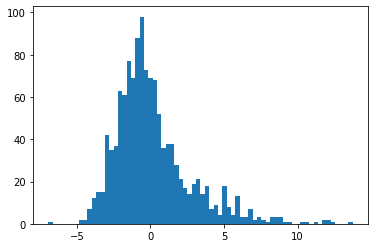

In [440]:
plt.hist(e, bins = 70)
plt.show()

,sumsquare_error,aic,bic,kl_div
lognorm,0.054450,993.185840,-12574.491668,inf
gamma,0.066221,992.634628,-12329.057472,inf
norm,0.119676,1059.542876,-11594.090041,inf


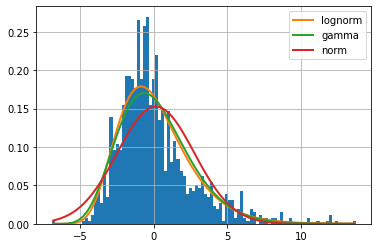

In [441]:
f = Fitter(resid,
           distributions=['gamma',
                          'lognorm',
                          "norm"])
f.fit()
f.summary()

In [442]:
f.get_best(method = 'sumsquare_error')

{'lognorm': {'s': 0.2903536283203024,
  'loc': -8.223766419970094,
  'scale': 8.000632973645498}}

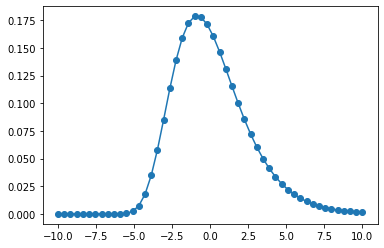

In [438]:
from pylab import linspace, plot 
import scipy.stats.lognorm as dist

X = linspace(-10,10, 50)
pdf_fitted = dist.pdf(X, 
                      s = 0.2903536283203024,
                      loc = -8.223766419970094,
                      scale = 8.000632973645498)


In [446]:
# new prediction
X_pred = pd.DataFrame({'Length':[134.0],
                    'Diameter':[101.0],
                    'Height': [32.0]})

X_pred = X_pred / 200

In [447]:
X_pred

,Length,Diameter,Height
0,0.67,0.505,0.16


In [448]:
best_knn.predict(X_pred)

array([12.40666667])

In [ ]:
X = linspace(-10,10, 50)
pdf_fitted = dist.pdf(X, 
                      s = 0.2903536283203024,
                      loc = -8.223766419970094,
                      scale = 8.000632973645498)


In [450]:
min(y), max(y)

(2.5, 30.5)

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 6.02608710e-30, 3.31600421e-16, 6.07544027e-11,
       4.82501307e-08, 3.35228147e-06, 6.13050631e-05, 4.93298864e-04,
       2.30238395e-03, 7.33955114e-03, 1.77229913e-02, 3.47349915e-02,
       5.79687716e-02, 8.52657905e-02, 1.13381170e-01, 1.38935985e-01,
       1.59219572e-01, 1.72619607e-01, 1.78675430e-01, 1.77872433e-01,
       1.71321133e-01, 1.60433763e-01, 1.46663144e-01, 1.31326693e-01,
       1.15511160e-01, 1.00040501e-01, 8.54860591e-02, 7.22005691e-02,
       6.03620203e-02, 5.00181640e-02, 4.11264118e-02, 3.35867562e-02,
       2.72672201e-02, 2.20224070e-02, 1.77062291e-02, 1.41800301e-02,
       1.13172565e-02, 9.00566624e-03, 7.14787367e-03, 5.66083575e-03,
       4.47472462e-03, 3.53149573e-03, 2.78335819e-03, 2.19127766e-03,
       1.72358703e-03, 1.35474332e-03])

In [ ]:
plot(X, 
     pdf_fitted, 
     'o-')

In [427]:
# neural net classification